## Why label encoding and one-hot encoding can be misused

- if categorical variables are not ordinal, label encoding with sequential integers might lead to an unintended order of labels (i.e. higher, smaller, greater, weaker) which means linear models or SVM interpret the label-encoded values as having a numerical relationship, and KNN might calculate the distances between the categories incorrectly or simply with incorrect intention
- if many categories, one-hot encoding might produce too many binary columns, causing high-dimensionality and sparse issues, hard to analyze/process data

## Let's try learned embeddings vectors

- known as embeddings, encodings, representations, or distributed representations
- create vectors of some dimension and of real numbers
- dense and low-dimensional vectors
- more robust to different types of categorical variables
- but requires understanding of the models (i.e. neural net), hyperparams, validation metrics, and computational resources to get these embeddings

### Categorical but already numerics

Janosi,Andras, Steinbrunn,William, Pfisterer,Matthias, and Detrano,Robert. (1988). Heart Disease. UCI Machine Learning Repository. https://doi.org/10.24432/C52P4X.

In this situation, we need to ask for data dictionary because the categories are in predefined integers, we need to know if these numbers are ordinal or not and refer to what.

### Categorical, strings, non-ordinal

Becker,Barry and Kohavi,Ronny. (1996). Adult. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.

Note that this experiment ignores other important initial analyses like correlation analysis, mutual information, variable selection. It focuses on implementing several learned embeddings on categorical variables.

In [161]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [184]:
# adult income

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
# for i, m in adult.metadata.items():
#     print(i, m)
  
# variable information 
adult.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,N/A,None,no
1,workclass,Feature,Categorical,Income,"Private, Self-emp-not-inc, Self-emp-inc, Feder...",None,yes
2,fnlwgt,Feature,Integer,None,None,None,no
3,education,Feature,Categorical,Education Level,"Bachelors, Some-college, 11th, HS-grad, Prof-...",None,no
4,education-num,Feature,Integer,Education Level,None,None,no
5,marital-status,Feature,Categorical,Other,"Married-civ-spouse, Divorced, Never-married, S...",None,no
6,occupation,Feature,Categorical,Other,"Tech-support, Craft-repair, Other-service, Sal...",None,yes
7,relationship,Feature,Categorical,Other,"Wife, Own-child, Husband, Not-in-family, Other...",None,no
8,race,Feature,Categorical,Race,"White, Asian-Pac-Islander, Amer-Indian-Eskimo,...",None,no
9,sex,Feature,Binary,Sex,"Female, Male.",None,no


In [197]:
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

df = X.copy()
df['target'] = y

# Perform stratified sampling to get 300 observations
sampled_df, _ = train_test_split(df, test_size=df.shape[0] - 300, stratify=df['target'], random_state=42)

# Separate features and targets again
X = sampled_df.drop(columns=['target'])
y = sampled_df['target']

print(f"Sampled Features Shape: {X.shape}")
print(f"Sampled Targets Shape: {y.shape}")

Sampled Features Shape: (300, 14)
Sampled Targets Shape: (300,)


In [198]:
# cleaning y
labels_replace = {'<=50K': 0, '>50K': 1}
y = y.str.replace(".", "").map(labels_replace)

# understand X
X.fillna("Unknown", inplace=True)
# understand distributions and unique of X
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 38251 to 28924
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             300 non-null    int64 
 1   workclass       300 non-null    object
 2   fnlwgt          300 non-null    int64 
 3   education       300 non-null    object
 4   education-num   300 non-null    int64 
 5   marital-status  300 non-null    object
 6   occupation      300 non-null    object
 7   relationship    300 non-null    object
 8   race            300 non-null    object
 9   sex             300 non-null    object
 10  capital-gain    300 non-null    int64 
 11  capital-loss    300 non-null    int64 
 12  hours-per-week  300 non-null    int64 
 13  native-country  300 non-null    object
dtypes: int64(6), object(8)
memory usage: 35.2+ KB


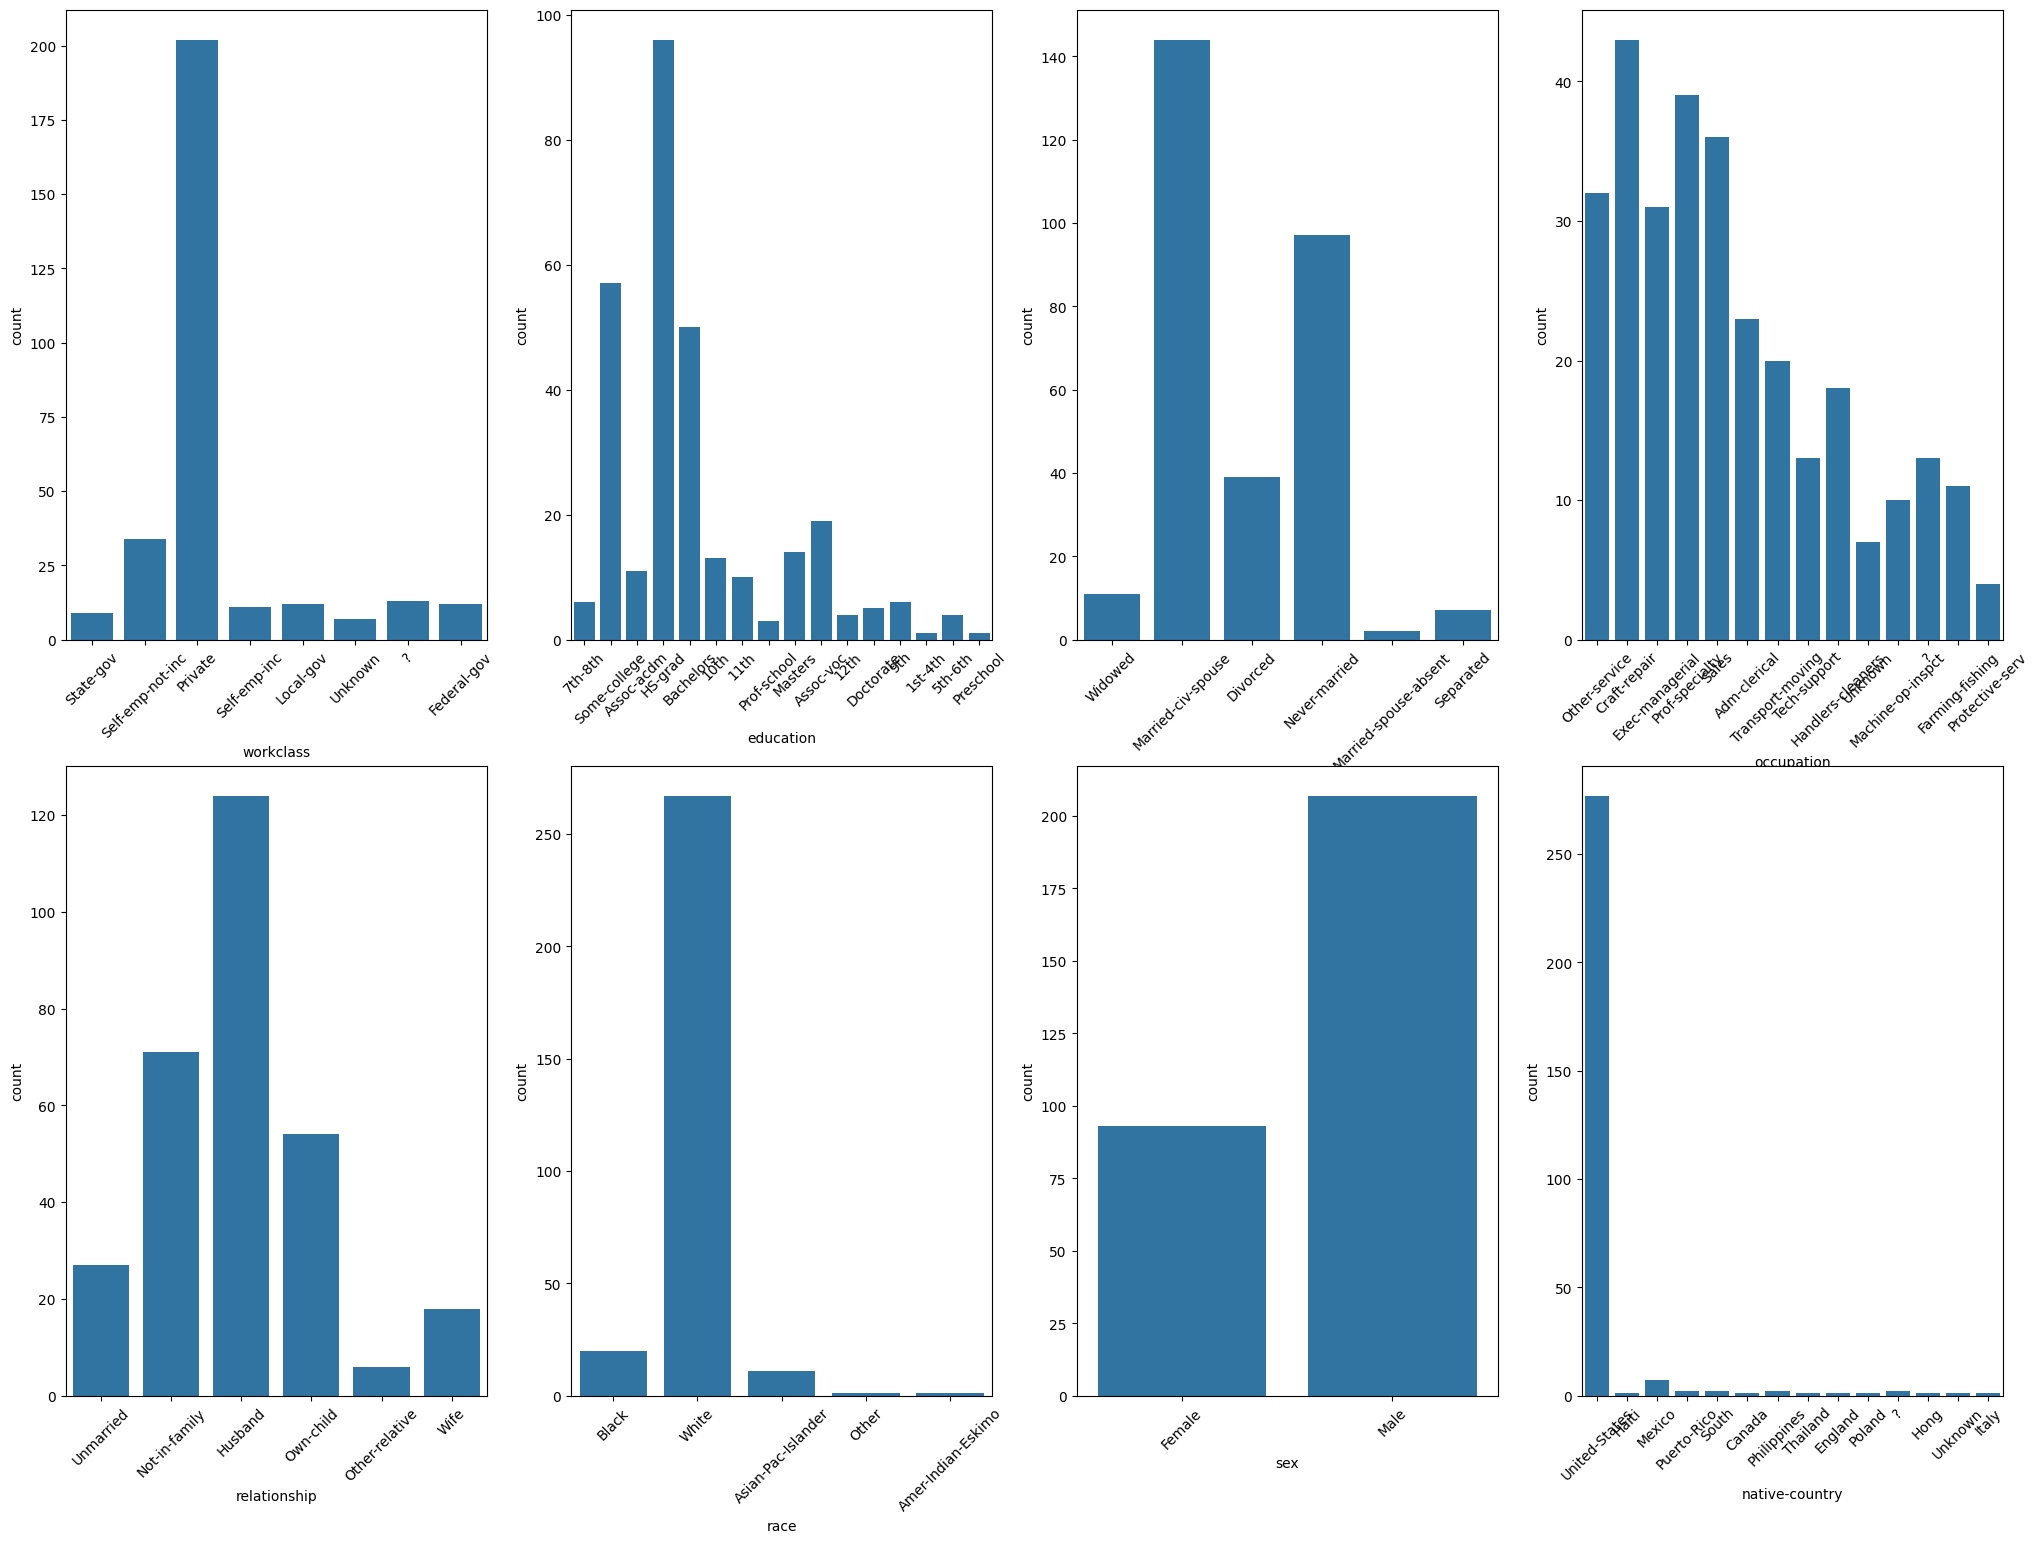

In [199]:
# categorical variables plots
categorical_vars = [col for col in X.columns if X[col].dtypes == 'object']

rows, cols = int(len(categorical_vars)/4), 4
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(25, 18))

for i in range(rows):
    for j in range(cols):
        sns.countplot(x=X[categorical_vars[i * cols + j]], ax=ax[i][j])
        ax[i, j].tick_params(axis='x', rotation=45)

Observations:

- No variables are ordinal maybe except for `education`
- `workclass`: most surveytakers are in the private industry
- `education`: most have bachelors and some college
- `marital-status`: most are single or married
- `occupation`: varies
- `relationship`: need to understand this, assume most are husbands and singles
- `race`: most are white => can distort predictions
- `sex`: mostly males 
- `native-country`: extremely leaning to US citizenship

Note that `sex` is binary so it's simple to be converted into 0 and 1, but let's try the embeddings.

In [200]:
# unique values
for col in categorical_vars:
    print(col,  X[col].unique(), '\n')

workclass ['State-gov' 'Self-emp-not-inc' 'Private' 'Self-emp-inc' 'Local-gov'
 'Unknown' '?' 'Federal-gov'] 

education ['7th-8th' 'Some-college' 'Assoc-acdm' 'HS-grad' 'Bachelors' '10th' '11th'
 'Prof-school' 'Masters' 'Assoc-voc' '12th' 'Doctorate' '9th' '1st-4th'
 '5th-6th' 'Preschool'] 

marital-status ['Widowed' 'Married-civ-spouse' 'Divorced' 'Never-married'
 'Married-spouse-absent' 'Separated'] 

occupation ['Other-service' 'Craft-repair' 'Exec-managerial' 'Prof-specialty' 'Sales'
 'Adm-clerical' 'Transport-moving' 'Tech-support' 'Handlers-cleaners'
 'Unknown' 'Machine-op-inspct' '?' 'Farming-fishing' 'Protective-serv'] 

relationship ['Unmarried' 'Not-in-family' 'Husband' 'Own-child' 'Other-relative' 'Wife'] 

race ['Black' 'White' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo'] 

sex ['Female' 'Male'] 

native-country ['United-States' 'Haiti' 'Mexico' 'Puerto-Rico' 'South' 'Canada'
 'Philippines' 'Thailand' 'England' 'Poland' '?' 'Hong' 'Unknown' 'Italy'] 



### Train an embedding model

Propose this:
- emb_size = $min(50, (m/2)+1)$
- emb_size is size of output dimension of an embedding layer.
- $m$ is the number of unique categories of a feature

In [171]:
# splitting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=123)

SVD as a learned embedding or LSA (latent semantic analysis)

matrix factorization

LSA is able to extract the relations between the values of
different categorical variables, but is often worse at differentiating between the categorical variables themselves. This is
indicated by the less clearly defined clusters of variables.
True to its original goal, GloVe performs equally well at
extracting relations and recognizing different categorical variables while respecting the distances between the embedded
variable clusters

In [201]:
# let try on one variable first: workclass and education 

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract relevant columns
data = X[['workclass', 'race']]

# Combine the two columns into a single text field for LSA
data['combined'] = data['workclass'] + ' ' + data['race']

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the combined text data
tfidf_matrix = vectorizer.fit_transform(data['combined'])

# Initialize and fit Truncated SVD
svd = TruncatedSVD(n_components=2)
lsa_matrix = svd.fit_transform(tfidf_matrix)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_37556\2515462423.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['combined'] = data['workclass'] + ' ' + data['race']


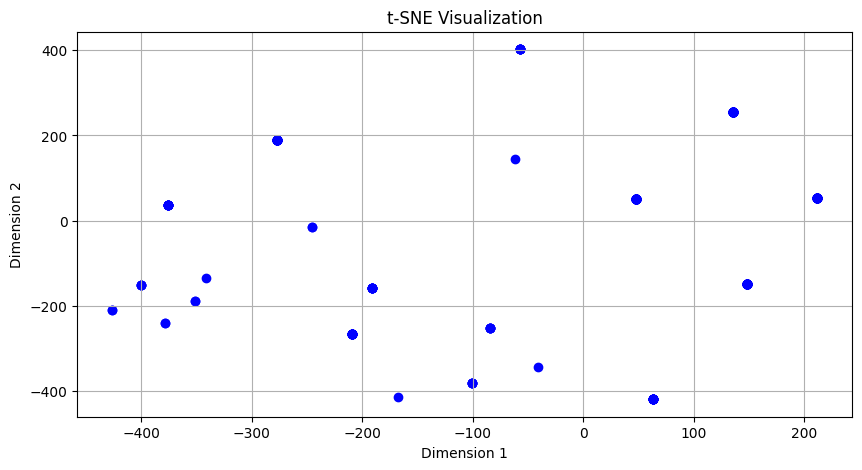

In [202]:
# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(lsa_matrix)

# Plot t-SNE results
plt.figure(figsize=(10, 5))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='blue', marker='o')
plt.title('t-SNE Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

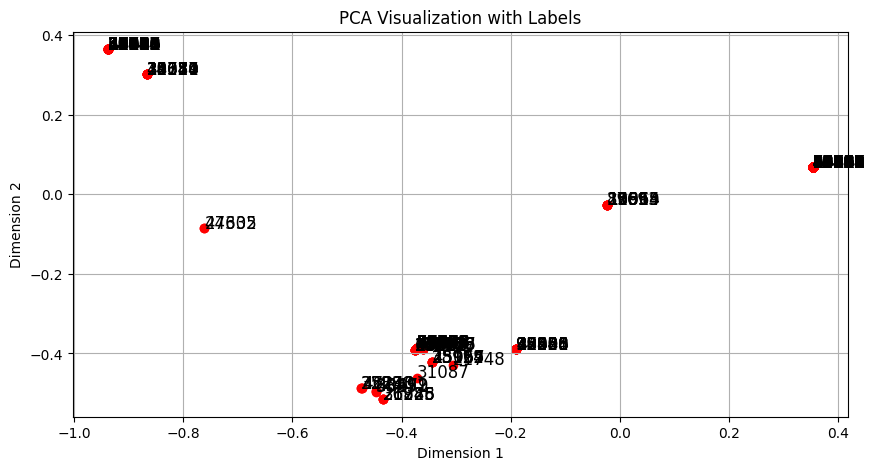

In [204]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(lsa_matrix)

# Plot PCA results with labels
plt.figure(figsize=(10, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='red', marker='o')

# Annotate each point with its index (or label)
for i, txt in enumerate(data.index):
    plt.text(pca_result[i, 0], pca_result[i, 1], str(txt), fontsize=12)

plt.title('PCA Visualization with Labels')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

NN as a learned embedding